# B. State purification with qubit-mediated measurement

In [1]:
# ruff: noqa
import os

os.sys.path.append("..")
from feedback_grape.fgrape import optimize_pulse_with_feedback
import jax.numpy as jnp

## The cavity is initially in a  mixed state --> Goal is to purify the state

We are trying to maximize the property determined by $tr (\rho_{\text{cav}}^2)$ which is the purity

In the following, we consider an adaptive measurement
scheme, demonstrated in a series of experiments on Rydberg atoms interacting
with microwave cavities. In this scheme, the
cavity is coupled to an ancilla qubit, which can then be
read out to update our knowledge of the quantum state of
the cavity.

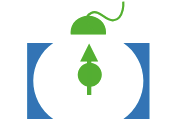

In [2]:
# initial state is a thermal state
n_average = 2
N_cavity = 30
# natural logarithm
beta = jnp.log((1 / n_average) + 1)
diags = jnp.exp(-beta * jnp.arange(N_cavity))
normalized_diags = diags / jnp.sum(diags, axis=0)
rho_cav = jnp.diag(normalized_diags)

### Now the thing is here, we don't need a rho_final because the purity or the reward that we want to maximize is $tr (\rho_{\text{cav}}^2)$.
Unlike fidelity expressions which wants to find how close to states are

## Next Step is to construct our POVM

In [3]:
from feedback_grape.utils.operators import cosm, sinm

In [4]:
from feedback_grape.utils.operators import create, destroy
import jax


def povm_measure_operator(measurement_outcome, params):
    """
    POVM for the measurement of the cavity state.
    returns Mm ( NOT the POVM element Em = Mm_dag @ Mm ), given measurement_outcome m, gamma and delta
    """
    # TODO: see if there is a better way other than flattening
    gamma, delta = params
    number_operator = create(N_cavity) @ destroy(N_cavity)
    angle = (gamma * number_operator) + delta / 2
    return jnp.where(
        measurement_outcome == 1,
        cosm(angle),
        sinm(angle),
    )

In [5]:
povm_measure_operator(1, [0.1, 0.5])

Array([[ 9.46538687e-01+0.j, -5.59640191e-02+0.j, -5.82155064e-02+0.j,
        -6.02009371e-02+0.j, -6.19076192e-02+0.j, -6.33254498e-02+0.j,
        -6.44468814e-02+0.j, -6.52669966e-02+0.j, -6.57837987e-02+0.j,
        -6.59980029e-02+0.j, -6.59132302e-02+0.j, -6.55358210e-02+0.j,
        -6.48750439e-02+0.j, -6.39429241e-02+0.j, -6.27542138e-02+0.j,
        -6.13260902e-02+0.j, -5.96783236e-02+0.j, -5.78330159e-02+0.j,
        -5.58143780e-02+0.j, -5.36484867e-02+0.j, -5.13633452e-02+0.j,
        -4.89883870e-02+0.j, -4.65542860e-02+0.j, -4.40927744e-02+0.j,
        -4.16363776e-02+0.j, -3.92180234e-02+0.j, -3.68708596e-02+0.j,
        -3.46279070e-02+0.j, -3.25218067e-02+0.j, -3.05845700e-02+0.j],
       [-5.59639931e-02+0.j,  9.36660409e-01+0.j, -6.04670122e-02+0.j,
        -6.23194017e-02+0.j, -6.38888031e-02+0.j, -6.51658475e-02+0.j,
        -6.61434233e-02+0.j, -6.68174773e-02+0.j, -6.71866238e-02+0.j,
        -6.72522634e-02+0.j, -6.70186728e-02+0.j, -6.64929599e-02+0.j,
     

In [6]:
# TODO: Have a default NN and then give user the ability to supply a model or a function
# With log p terms: 0.0.9984141684258416
# Without log p terms: 0.999796307373522
# QUESTION: why does RNN outputs two the same, then two the same, then two the same and so on?
result = optimize_pulse_with_feedback(
    U_0=rho_cav,
    C_target=None,
    parameterized_gates=[povm_measure_operator],
    measurement_indices=[0],
    initial_params=[0.1, -3 * jnp.pi / 2],
    num_time_steps=5,
    mode="nn",
    goal="purity",
    optimizer="adam",
    max_iter=1000,
    convergence_threshold=1e-6,
    learning_rate=0.1,
    type="density",
)

RNN output: [0. 0.]
RNN output: [-0.07171017  0.0165677 ]
RNN output: [-0.07171017  0.0165677 ]
RNN output: [-0.14636515 -0.00216124]
RNN output: [-0.14636515 -0.00216124]
RNN output: [-0.20784187 -0.02698774]
RNN output: [-0.20784187 -0.02698774]
RNN output: [-0.25288278 -0.0485783 ]
RNN output: [-0.25288278 -0.0485783 ]
RNN output: [-0.28326491 -0.06518285]
RNN output: [-0.28326491 -0.06518285]
RNN output: [-0.97100239 -0.54070143]
RNN output: [-0.97100239 -0.54070143]
RNN output: [-1.98161684 -0.8816789 ]
RNN output: [-1.98161684 -0.8816789 ]
RNN output: [-2.72252099 -1.09142469]
RNN output: [-2.72252099 -1.09142469]
RNN output: [-3.07387435 -1.20360741]
RNN output: [-3.07387435 -1.20360741]
RNN output: [-3.172966   -1.25494022]
RNN output: [-3.172966   -1.25494022]
RNN output: [-0.49872053 -0.0354651 ]
RNN output: [-0.49872053 -0.0354651 ]
RNN output: [-0.51149478  0.13576542]
RNN output: [-0.51149478  0.13576542]
RNN output: [-0.30082247  0.17952008]
RNN output: [-0.30082247  0.17

In [7]:
print(result.final_purity)

0.9997574975827752


In [8]:
from feedback_grape.fgrape import (
    _probability_of_a_measurement_outcome_given_a_certain_state,
)
# from feedback_grape.fgrape import (
#     _probability_of_a_measurement_outcome_given_a_certain_state,
# )

variables = jnp.array([0.1, -3 * jnp.pi / 2])
# variables_2 = {
#     "gamma": 0.1,
#     "delta": -3 * jnp.pi / 2,
# }
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, -1, povm_measure_operator, variables
    )
)
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, 1, povm_measure_operator, variables
    )
)

0.09735403621715237
0.9026459637828469


In [9]:
# TODO: See why this outputs sth different fromt the purity in the result
from feedback_grape.utils.purity import purity

print("initial purity:", purity(rho=rho_cav))
print("Final purity:", purity(rho=result.final_state))

initial purity: 0.20000208604889932
Final purity: 0.9997574975827752


In [10]:
print("Purity in object: ", result.final_purity)

Purity in object:  0.9997574975827752


In [11]:
result.arr_of_povm_params

[[0.1, -4.71238898038469],
 Array([-0.77760833, -0.03661956], dtype=float64),
 Array([-1.37332101, -0.022743  ], dtype=float64),
 Array([-1.17792831, -0.00595258], dtype=float64),
 Array([-1.56986814, -0.00539041], dtype=float64)]

### Check stash for replacement of dict implementation

In [12]:
from feedback_grape.fgrape import povm

time_steps = 5

rho = rho_cav
print("initial purity:", purity(rho=rho))
for i in range(time_steps):
    params = result.arr_of_povm_params[i]
    rho, _, _ = povm(rho, povm_measure_operator, params)
    print(f"purity of rho after time step {i}", purity(rho=rho))
final_rho_cav = rho

initial purity: 0.20000208604889932
purity of rho after time step 0 0.22906358179156958
purity of rho after time step 1 0.39031952457150276
purity of rho after time step 2 0.7067740822548574
purity of rho after time step 3 0.8735543937082166
purity of rho after time step 4 0.9997574975827752


In [13]:
print("Final state after application of amplitudes:", final_rho_cav)

Final state after application of amplitudes: [[ 9.99857926e-01+0.j -1.69524333e-03+0.j  1.92955940e-03+0.j
  -5.73120070e-04+0.j -6.11445536e-04+0.j -3.32037726e-04+0.j
  -1.44938807e-04+0.j -2.25284293e-04+0.j  6.02122819e-04+0.j
  -1.63795837e-04+0.j  8.04245154e-04+0.j -1.13387996e-04+0.j
  -2.00677325e-04+0.j -1.54929227e-04+0.j -7.72529212e-04+0.j
  -1.09347962e-04+0.j  3.05373944e-03+0.j -1.07876797e-04+0.j
  -6.96550652e-04+0.j -1.24280596e-04+0.j -1.27444203e-04+0.j
   3.06947141e-05+0.j  7.86837483e-04+0.j -1.30471696e-05+0.j
   6.00278125e-05+0.j  6.02787400e-05+0.j  9.54799234e-04+0.j
   2.18968886e-04+0.j -1.31776911e-04+0.j -3.82645226e-04+0.j]
 [-1.69524333e-03+0.j  2.87813242e-06+0.j -3.52305054e-06+0.j
   9.72289041e-07+0.j  1.03600384e-06+0.j  5.62353122e-07+0.j
   2.74836289e-07+0.j  3.81219703e-07+0.j -1.03461121e-06+0.j
   2.76629003e-07+0.j -1.38947214e-06+0.j  1.90547844e-07+0.j
   3.40248768e-07+0.j  2.63809625e-07+0.j  1.33083391e-06+0.j
   1.85300647e-07+0.j -5

In [14]:
print("Final state from solver:", result.final_state)

Final state from solver: [[ 9.99857926e-01+0.j -1.69524333e-03+0.j  1.92955940e-03+0.j
  -5.73120070e-04+0.j -6.11445536e-04+0.j -3.32037726e-04+0.j
  -1.44938807e-04+0.j -2.25284293e-04+0.j  6.02122819e-04+0.j
  -1.63795837e-04+0.j  8.04245154e-04+0.j -1.13387996e-04+0.j
  -2.00677325e-04+0.j -1.54929227e-04+0.j -7.72529212e-04+0.j
  -1.09347962e-04+0.j  3.05373944e-03+0.j -1.07876797e-04+0.j
  -6.96550652e-04+0.j -1.24280596e-04+0.j -1.27444203e-04+0.j
   3.06947141e-05+0.j  7.86837483e-04+0.j -1.30471696e-05+0.j
   6.00278125e-05+0.j  6.02787400e-05+0.j  9.54799234e-04+0.j
   2.18968886e-04+0.j -1.31776911e-04+0.j -3.82645226e-04+0.j]
 [-1.69524333e-03+0.j  2.87813242e-06+0.j -3.52305054e-06+0.j
   9.72289041e-07+0.j  1.03600384e-06+0.j  5.62353122e-07+0.j
   2.74836289e-07+0.j  3.81219703e-07+0.j -1.03461121e-06+0.j
   2.76629003e-07+0.j -1.38947214e-06+0.j  1.90547844e-07+0.j
   3.40248768e-07+0.j  2.63809625e-07+0.j  1.33083391e-06+0.j
   1.85300647e-07+0.j -5.31377215e-06+0.j  1